# Stock Price Prediction using ARIMA and Gradient Boosting

## Step 1: Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

## Step 2: Fetch and Prepare Data

In [4]:
import yfinance as yf

def fetch_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, auto_adjust=False)
    return data['Adj Close']

stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = fetch_data(stocks, '2020-01-01', '2024-01-01')

print(data.head())

[*********************100%***********************]  5 of 5 completed


Ticker           AAPL       AMZN      GOOGL        MSFT       TSLA
Date                                                              
2020-01-02  72.716072  94.900497  68.108376  153.323273  28.684000
2020-01-03  72.009125  93.748497  67.752075  151.414139  29.534000
2020-01-06  72.582916  95.143997  69.557945  151.805496  30.102667
2020-01-07  72.241554  95.343002  69.423584  150.421371  31.270666
2020-01-08  73.403641  94.598503  69.917725  152.817307  32.809334


## Step 3: Exploratory Data Analysis (EDA)

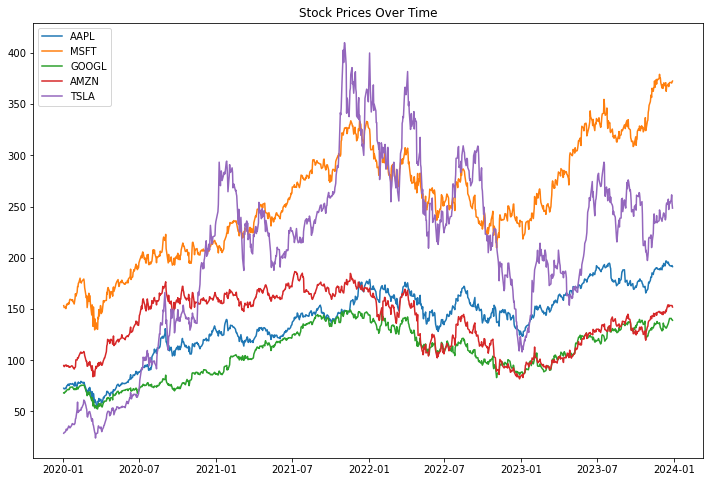

In [5]:
plt.figure(figsize=(12, 8))
for stock in stocks:
    plt.plot(data[stock], label=stock)
plt.legend()
plt.title('Stock Prices Over Time')
plt.show()

## Step 4: Feature Engineering

In [7]:
print(data.columns)


Index(['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA'], dtype='object', name='Ticker')


In [8]:
print(data.head())


Ticker           AAPL       AMZN      GOOGL        MSFT       TSLA
Date                                                              
2020-01-02  72.716072  94.900497  68.108376  153.323273  28.684000
2020-01-03  72.009125  93.748497  67.752075  151.414139  29.534000
2020-01-06  72.582916  95.143997  69.557945  151.805496  30.102667
2020-01-07  72.241554  95.343002  69.423584  150.421371  31.270666
2020-01-08  73.403641  94.598503  69.917725  152.817307  32.809334


In [12]:
print(data.columns)  # Verify column names

Index(['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA'], dtype='object', name='Ticker')


In [13]:
data.columns = data.columns.get_level_values(0)

In [15]:
def create_lagged_features(series, lags=3):
    df = series.to_frame()  # Convert Series to DataFrame
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = series.shift(lag)  # Shift the original series, not the DataFrame
    df['returns'] = series.pct_change()
    df['rolling_mean'] = series.rolling(window=5).mean()
    df['rolling_std'] = series.rolling(window=5).std()
    df.dropna(inplace=True)
    return df

stock_data = create_lagged_features(data['AAPL'])
print(stock_data.head())

                 AAPL      lag_1      lag_2      lag_3   returns  \
Date                                                               
2020-01-08  73.403641  72.241554  72.582916  72.009125  0.016086   
2020-01-09  74.962791  73.403641  72.241554  72.582916  0.021241   
2020-01-10  75.132271  74.962791  73.403641  72.241554  0.002261   
2020-01-13  76.737419  75.132271  74.962791  73.403641  0.021364   
2020-01-14  75.701218  76.737419  75.132271  74.962791 -0.013503   

            rolling_mean  rolling_std  
Date                                   
2020-01-08     72.590662     0.533100  
2020-01-09     73.040005     1.197759  
2020-01-10     73.664635     1.332531  
2020-01-13     74.495535     1.726446  
2020-01-14     75.187468     1.214686  


In [16]:
def create_lagged_features(df, column_name='AAPL', lags=10):
    # Ensure df is a DataFrame and select the target column
    df = df[[column_name]].copy()

    # Create lagged features
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[column_name].shift(lag)

    # Add returns and rolling statistics
    df['returns'] = df[column_name].pct_change()
    df['rolling_mean'] = df[column_name].rolling(window=5).mean()
    df['rolling_std'] = df[column_name].rolling(window=5).std()

    # Drop rows with NaN values
    df.dropna(inplace=True)
    return df

# Pass the full DataFrame and specify the target column
stock_data = create_lagged_features(data, 'AAPL')

print(stock_data.head())

Ticker           AAPL      lag_1      lag_2      lag_3      lag_4      lag_5  \
Date                                                                           
2020-01-16  76.320992  75.376801  75.701218  76.737419  75.132271  74.962791   
2020-01-17  77.165955  76.320992  75.376801  75.701218  76.737419  75.132271   
2020-01-21  76.642990  77.165955  76.320992  75.376801  75.701218  76.737419   
2020-01-22  76.916565  76.642990  77.165955  76.320992  75.376801  75.701218   
2020-01-23  77.287010  76.916565  76.642990  77.165955  76.320992  75.376801   

Ticker          lag_6      lag_7      lag_8      lag_9     lag_10   returns  \
Date                                                                          
2020-01-16  73.403641  72.241554  72.582916  72.009125  72.716072  0.012526   
2020-01-17  74.962791  73.403641  72.241554  72.582916  72.009125  0.011071   
2020-01-21  75.132271  74.962791  73.403641  72.241554  72.582916 -0.006777   
2020-01-22  76.737419  75.132271  74.962791 

In [19]:
def create_lagged_features(df, column_name, lags=10):
    # Create a new DataFrame with the specified column
    df_lagged = df[[column_name]].copy()

    # Generate lag features
    for lag in range(1, lags + 1):
        df_lagged[f'lag_{lag}'] = df_lagged[column_name].shift(lag)

    # Add returns and rolling statistics
    df_lagged['returns'] = df_lagged[column_name].pct_change()
    df_lagged['rolling_mean'] = df_lagged[column_name].rolling(window=5).mean()
    df_lagged['rolling_std'] = df_lagged[column_name].rolling(window=5).std()

    # Drop rows with NaN values (caused by shifting)
    df_lagged.dropna(inplace=True)

    return df_lagged


In [20]:
stock_data = create_lagged_features(data, 'AAPL')
print(stock_data.head())

Ticker           AAPL      lag_1      lag_2      lag_3      lag_4      lag_5  \
Date                                                                           
2020-01-16  76.320992  75.376801  75.701218  76.737419  75.132271  74.962791   
2020-01-17  77.165955  76.320992  75.376801  75.701218  76.737419  75.132271   
2020-01-21  76.642990  77.165955  76.320992  75.376801  75.701218  76.737419   
2020-01-22  76.916565  76.642990  77.165955  76.320992  75.376801  75.701218   
2020-01-23  77.287010  76.916565  76.642990  77.165955  76.320992  75.376801   

Ticker          lag_6      lag_7      lag_8      lag_9     lag_10   returns  \
Date                                                                          
2020-01-16  73.403641  72.241554  72.582916  72.009125  72.716072  0.012526   
2020-01-17  74.962791  73.403641  72.241554  72.582916  72.009125  0.011071   
2020-01-21  75.132271  74.962791  73.403641  72.241554  72.582916 -0.006777   
2020-01-22  76.737419  75.132271  74.962791 

## Step 5: Optimized ARIMA Model

In [21]:
def auto_arima(train):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in range(5):
        for d in range(2):
            for q in range(5):
                try:
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except:
                    continue
    print("Best ARIMA Order:", best_order)
    return best_model

train_size = int(len(stock_data) * 0.8)
train, test = stock_data[:train_size]['AAPL'], stock_data[train_size:]['AAPL']

arima_model = auto_arima(train)
arima_preds = arima_model.forecast(steps=len(test))

Best ARIMA Order: (4, 1, 2)


In [22]:
# Evaluate ARIMA
print("ARIMA RMSE:", mean_squared_error(test, arima_preds, squared=False))
print("ARIMA MAE:", mean_absolute_error(test, arima_preds))
print("ARIMA MAPE:", mean_absolute_percentage_error(test, arima_preds))

ARIMA RMSE: 28.802974743338236
ARIMA MAE: 26.720580930075435
ARIMA MAPE: 0.14690775279528848


## Step 6: Optimized Gradient Boosting Model

In [23]:
def xgboost_model(df):
    X = df.drop(columns='AAPL')
    y = df['AAPL']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = XGBRegressor(objective='reg:squarederror')

    params = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }

    grid_search = GridSearchCV(model, param_grid=params, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    print("Best XGBoost Parameters:", grid_search.best_params_)

    best_model = grid_search.best_estimator_
    preds = best_model.predict(X_test)

    print("XGBoost RMSE:", mean_squared_error(y_test, preds, squared=False))
    print("XGBoost MAE:", mean_absolute_error(y_test, preds))
    print("XGBoost MAPE:", mean_absolute_percentage_error(y_test, preds))

    return preds, y_test

xgb_preds, y_test = xgboost_model(stock_data)

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
XGBoost RMSE: 8.666467804399478
XGBoost MAE: 5.798538589477539
XGBoost MAPE: 0.030782532340342686


## Step 7: Visualize Results

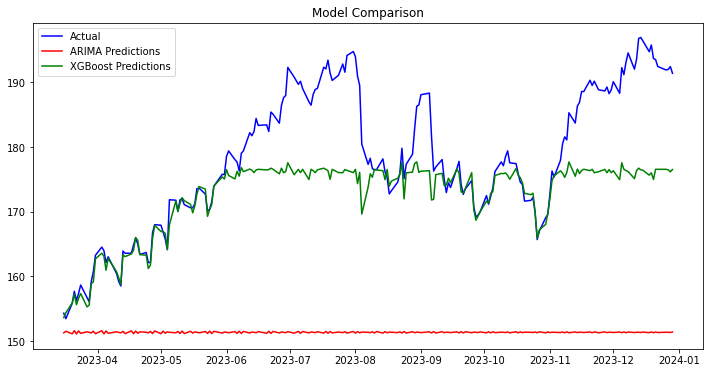

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, arima_preds, label='ARIMA Predictions', color='red')
plt.plot(y_test.index, xgb_preds, label='XGBoost Predictions', color='green')
plt.legend()
plt.title('Model Comparison')
plt.show()